In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import create_train_test

In [3]:
X_raw_train, X_raw_test, y_train_list, y_test_list = create_train_test()

In [5]:
from nltk.corpus import stopwords 

def remove_stop_words(X_list):
    stop_words = set(stopwords.words('english')) 
  
    X_wsw_list = []
    for x_file in X_list:
        x_file_wsw = []
        for sentence in x_file:
            words = nltk.word_tokenize(sentence)
            words = [w for w in words if not w in stop_words]
            if len([w for w in words if not w in stop_words]) > 0:
                x_file_wsw.append(" ".join(words))
        X_wsw_list.append(x_file_wsw)
    return X_wsw_list

X_train_trans_list = remove_stop_words(X_raw_train)
X_test_trans_list = remove_stop_words(X_raw_test)

In [6]:
from termcolor import colored
file_number = 7

for sent, label in zip(X_train_trans_list[file_number], y_train_list[file_number]):
    if label == 1:
        print(colored(sent, 'red'))
    else:
        print(sent)

hi everyone
im bernie brown unlocking us
todays episode brought cft family foods
youve listened first podcast first one fft stands f first times
know one big fears podcasting advertising
ive kind fallen love decided would brands really love really love something like talking csj family foods fits bill
cft started 2014 veronica garza diagnosed auto immune disease give grain really hard used eating tortillas
veronica started making tortillas almond flour
grandmother important component story gave tortillas blessing
brother miguel started pitching tortillas local grocery stores
exact time ellen daughter diagnosed gluten intolerance go taco strike support ellen
found csa tortillas almond flour tortillas grocery store
love affair semetic emily foods begins today
tacos
say kids really sad realized families say taco tuesday actually mean tacos tuesday house everyday taco tuesday
brings new taco seasoning
many brands taco seasoning market gluten things ellen cant eat try eat dont eat
theres br

In [8]:
from utils import create_ft_sent_vectors
create_ft_sent_vectors(X_train_trans_list, X_test_trans_list, y_train_list, y_test_list, "sent_without_sw.pkl",
                          epoch=200, minn=1, maxn=6, dim=100, model='skipgram')

Number of sentences: 19354
Train unsupervised model.
Model trained with user parameters:
{'verbose': 1, 'epoch': 200, 'minn': 1, 'maxn': 6, 'dim': 100, 'model': 'skipgram'}.


In [3]:
import pickle
with open("sent_without_sw.pkl", 'rb') as f:
    X_train_list, X_test_list, y_train_list, y_test_list = pickle.load(f)

In [4]:
from utils import create_rec_data

X_train_rec, y_train_rec, mask_train_rec = create_rec_data(X_train_list, y_train_list, 50)
X_test_rec, y_test_rec, mask_test_rec = create_rec_data(X_test_list, y_test_list, 50)
y_train_rec = y_train_rec[:, :, None]
y_test_rec = y_test_rec[:, :, None]

print(X_train_rec.shape, y_train_rec.shape, mask_train_rec.shape)
print(X_test_rec.shape, y_test_rec.shape, mask_test_rec.shape)

(402, 50, 100) (402, 50, 1) (402, 50)
(136, 50, 100) (136, 50, 1) (136, 50)


In [5]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dropout, Bidirectional, TimeDistributed, GRU, Dense
from tensorflow.keras.metrics import Precision, Recall

max_sent = 50
features = 100

metrics=[Precision(), Recall()]

In [6]:
seed = 1
tf.random.set_seed(seed)

input = Input(shape=(max_sent, features))
model = Dropout(0.4)(input)
model = Bidirectional(GRU(units=200, return_sequences=True, recurrent_dropout=0.1))(model) 
model = Dropout(0.4)(model)
model = TimeDistributed(Dense(100, activation="sigmoid"))(model) 
model = Dropout(0.4)(model)
out = TimeDistributed(Dense(1, activation="sigmoid"))(model)  

model = Model(input, out)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=metrics)

In [7]:
from os.path import exists, join
from os import mkdir

weight_dir = 'weights_lemma_wsw'
checkpoint_filepath = join(weight_dir, 'saved-weight-{epoch:02d}.hdf5')

if not exists(weight_dir):
    mkdir(weight_dir)


saver_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=False,
    save_freq=1)

history = model.fit(X_train_rec, y_train_rec, batch_size=50, epochs=200, callbacks=[saver_callback], validation_data=(X_test_rec, y_test_rec))

Epoch 1/200
9/9 [==============================] - 5s 509ms/step - loss: 0.5956 - precision: 0.0583 - recall: 0.3720 - val_loss: 0.1913 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
9/9 [==============================] - 4s 426ms/step - loss: 0.2250 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2180 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
9/9 [==============================] - 4s 426ms/step - loss: 0.2512 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1758 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
9/9 [==============================] - 4s 412ms/step - loss: 0.2174 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/200
9/9 [==============================] - 4s 418ms/step - loss: 0.2054 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/200
9/9 [======

Epoch 45/200
9/9 [==============================] - 4s 434ms/step - loss: 0.1035 - precision: 0.7715 - recall: 0.4187 - val_loss: 0.1075 - val_precision: 0.7660 - val_recall: 0.1295
Epoch 46/200
9/9 [==============================] - 4s 441ms/step - loss: 0.0957 - precision: 0.7394 - recall: 0.5305 - val_loss: 0.1044 - val_precision: 0.7368 - val_recall: 0.1511
Epoch 47/200
9/9 [==============================] - 4s 420ms/step - loss: 0.0984 - precision: 0.7129 - recall: 0.5376 - val_loss: 0.1126 - val_precision: 0.7586 - val_recall: 0.0791
Epoch 48/200
9/9 [==============================] - 4s 435ms/step - loss: 0.0976 - precision: 0.7965 - recall: 0.4136 - val_loss: 0.1050 - val_precision: 0.7632 - val_recall: 0.1043
Epoch 49/200
9/9 [==============================] - 4s 444ms/step - loss: 0.1034 - precision: 0.7260 - recall: 0.4848 - val_loss: 0.1036 - val_precision: 0.7455 - val_recall: 0.1475
Epoch 50/200
9/9 [==============================] - 4s 425ms/step - loss: 0.0954 - precisi

9/9 [==============================] - 4s 444ms/step - loss: 0.1199 - precision: 0.8986 - recall: 0.2612 - val_loss: 0.1300 - val_precision: 1.0000 - val_recall: 0.0216
Epoch 91/200
9/9 [==============================] - 4s 427ms/step - loss: 0.1211 - precision: 0.7315 - recall: 0.3211 - val_loss: 0.1015 - val_precision: 0.7500 - val_recall: 0.1727
Epoch 92/200
9/9 [==============================] - 4s 420ms/step - loss: 0.0938 - precision: 0.8262 - recall: 0.4736 - val_loss: 0.1182 - val_precision: 0.7170 - val_recall: 0.1367
Epoch 93/200
9/9 [==============================] - 4s 419ms/step - loss: 0.0882 - precision: 0.8292 - recall: 0.5132 - val_loss: 0.1073 - val_precision: 0.5287 - val_recall: 0.2986
Epoch 94/200
9/9 [==============================] - 4s 415ms/step - loss: 0.0931 - precision: 0.7652 - recall: 0.5498 - val_loss: 0.1267 - val_precision: 0.6389 - val_recall: 0.0827
Epoch 95/200
9/9 [==============================] - 4s 445ms/step - loss: 0.0854 - precision: 0.8257 - 

Epoch 135/200
9/9 [==============================] - 4s 425ms/step - loss: 0.0873 - precision: 0.8950 - recall: 0.5285 - val_loss: 0.1154 - val_precision: 0.6311 - val_recall: 0.2770
Epoch 136/200
9/9 [==============================] - 4s 414ms/step - loss: 0.0768 - precision: 0.7636 - recall: 0.6829 - val_loss: 0.1146 - val_precision: 0.7059 - val_recall: 0.0863
Epoch 137/200
9/9 [==============================] - 4s 410ms/step - loss: 0.0861 - precision: 0.7474 - recall: 0.6585 - val_loss: 0.1103 - val_precision: 0.5357 - val_recall: 0.1079
Epoch 138/200
9/9 [==============================] - 4s 430ms/step - loss: 0.0787 - precision: 0.8769 - recall: 0.5935 - val_loss: 0.1291 - val_precision: 0.4110 - val_recall: 0.1079
Epoch 139/200
9/9 [==============================] - 4s 429ms/step - loss: 0.0709 - precision: 0.8184 - recall: 0.6596 - val_loss: 0.1189 - val_precision: 0.5941 - val_recall: 0.2158
Epoch 140/200
9/9 [==============================] - 4s 422ms/step - loss: 0.0665 - p

Epoch 180/200
9/9 [==============================] - 4s 480ms/step - loss: 0.0597 - precision: 0.8666 - recall: 0.6799 - val_loss: 0.1255 - val_precision: 0.4667 - val_recall: 0.2518
Epoch 181/200
9/9 [==============================] - 4s 497ms/step - loss: 0.0592 - precision: 0.8110 - recall: 0.7632 - val_loss: 0.1287 - val_precision: 0.4203 - val_recall: 0.2086
Epoch 182/200
9/9 [==============================] - 4s 485ms/step - loss: 0.0672 - precision: 0.8443 - recall: 0.7053 - val_loss: 0.1232 - val_precision: 0.5079 - val_recall: 0.2302
Epoch 183/200
9/9 [==============================] - 4s 423ms/step - loss: 0.0596 - precision: 0.8034 - recall: 0.8140 - val_loss: 0.1312 - val_precision: 0.4444 - val_recall: 0.1583
Epoch 184/200
9/9 [==============================] - 4s 419ms/step - loss: 0.0581 - precision: 0.9099 - recall: 0.6982 - val_loss: 0.1303 - val_precision: 0.7083 - val_recall: 0.1223
Epoch 185/200
9/9 [==============================] - 4s 426ms/step - loss: 0.0652 - p

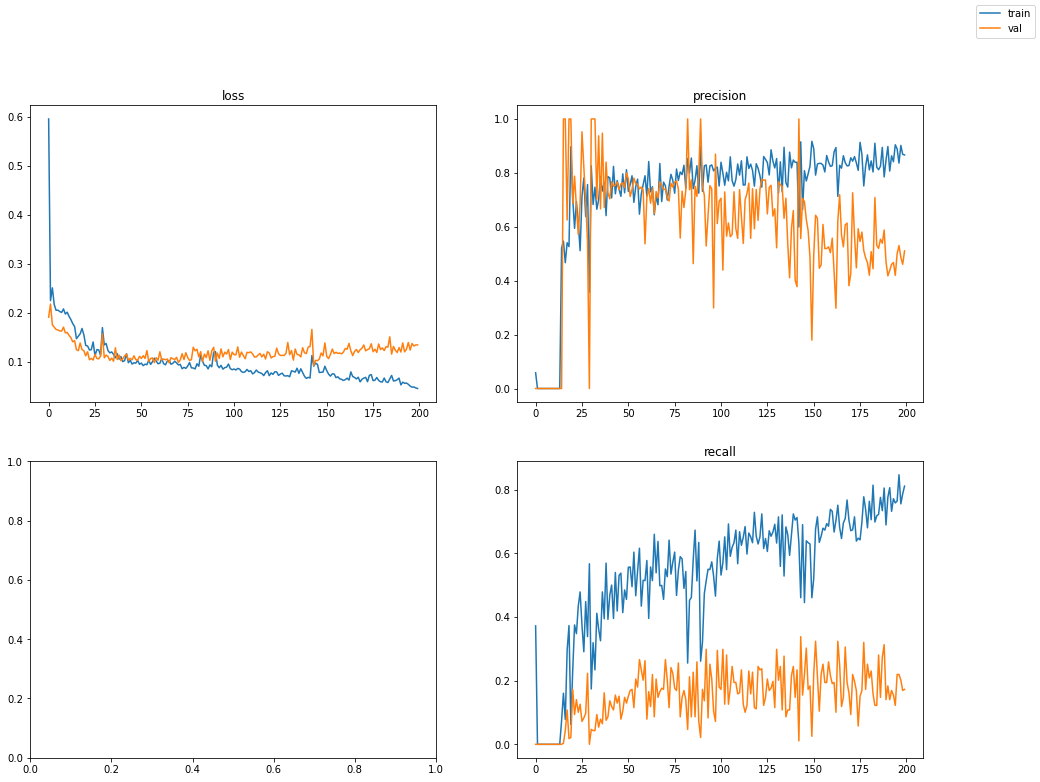

In [8]:
from utils import plot_loss_precision_recall
plot_loss_precision_recall(history.history['loss'], history.history['val_loss'], 
                           history.history['precision'], history.history['val_precision'], 
                           history.history['recall'], history.history['val_recall'])

In [9]:
best_epoch = 75
model.load_weights(checkpoint_filepath.format(epoch=best_epoch))
y_pred_probs = model.predict(X_test_rec)

In [10]:
from utils import make_flat

y_pred_probs_flat = make_flat(y_pred_probs, mask_test_rec) 
y_flat_true = make_flat(y_test_rec, mask_test_rec)

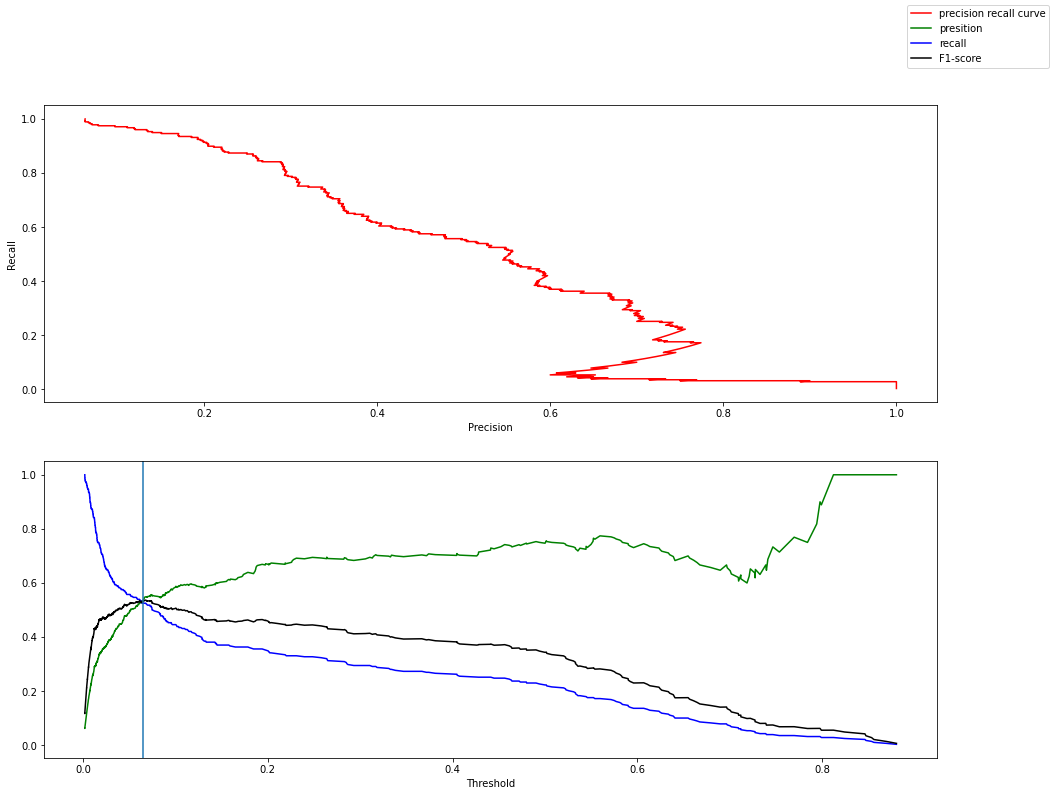

In [18]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_flat_true, y_pred_probs_flat)

fig, ax = plt.subplots(2, 1, figsize=(16, 12))

ax[0].plot(precisions[:-1], recalls[:-1], color='red', label='precision recall curve')
ax[0].set_xlabel("Precision")
ax[0].set_ylabel("Recall")

ax[1].plot(thresholds, precisions[:-1], color='green', label='presition')
ax[1].plot(thresholds, recalls[:-1],  color='blue',label='recall')
ax[1].plot(thresholds, 2*recalls[:-1]*precisions[:-1]/(recalls[:-1]+precisions[:-1]),  color='black',label='F1-score')
ax[1].axvline(x=0.065)
ax[1].set_xlabel("Threshold")

fig.legend()
plt.show()

In [19]:
import numpy as np
y_flat_pred = np.zeros_like(y_pred_probs_flat)
y_flat_pred[y_pred_probs_flat >= 0.065] = 1

In [20]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
print(f1_score(y_flat_true, y_flat_pred))
print(classification_report(y_flat_true, y_flat_pred))
print(confusion_matrix(y_flat_true, y_flat_pred))

0.5309090909090909
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      6309
         1.0       0.54      0.53      0.53       278

    accuracy                           0.96      6587
   macro avg       0.76      0.75      0.76      6587
weighted avg       0.96      0.96      0.96      6587

[[6183  126]
 [ 132  146]]
